# CS448 - Lab 5: Microphone Arrays

In this lab we will perform some simple microphone array processing. We will use the sound below:

[https://drive.google.com/uc?export=download&id=1emuGR4tlmemJ8RXSD1rWQwNx13h5X9VM ]

This is a recording from an 8-channel array. The microphones were placed at a distance of 0.1 meters from each other, and two simultaneous sounding sources were recorded. In the rest of this lab you will have to find where the sources are, and beamform so that you focus on each one separately.

In [1]:
### IMPORTS & SETUP ###

import matplotlib.pyplot as plt

plt.style.use('bmh')
plt.rcParams["figure.figsize"] = (4, 3)

import numpy as np
from scipy.io import wavfile
from scipy.signal import find_peaks

In [2]:
### UTILITIES ###


# Sound player function that plays array "x" with a sample rate "rate", and labels it with "label"
def sound(x, rate=8000, label=''):
    from IPython.display import display, Audio, HTML
    display(
        HTML('<style> table, th, td {border: 0px; }</style> <table><tr><td>' +
             label + '</td><td>' + Audio(x, rate=rate)._repr_html_()[3:] +
             '</td></tr></table>'))


# Function that normalizes a signal
def normalize_signal(x):
    return x / np.max(np.abs(x))


def plot_spectrogram(input_sound, fs, title="Spectrogram"):
    plt.title(title)
    plt.specgram(input_sound, Fs=fs, cmap="winter")
    plt.xlabel('Time [sec]')
    plt.ylabel('Frequency [Hz]')
    plt.show()

In [3]:
# Load the input sound and setup the parameters
fname = 'array.wav'
fs, input_sound = wavfile.read(f'./data/{fname}')
input_sound = input_sound.T
input_sound = normalize_signal(input_sound)

sound(input_sound, rate=fs, label=fname)

# Constants
num_mics = 8
num_freqs = 513
num_angles = 50

N = 1024
R = fs
C = 345
r = 0.1

dft_size = 1024
hop_size = 256
zero_pad = 0
window = np.hanning(dft_size)

array.wav


## Part 1: Getting the Steering Vectors

In order to do any further processing on this array we will need to obtain a set of steering vectors. As you might recall the steering vectors encode the phase shift that each frequency undergoes between all the microphones of the array for a given source location.  Since we will be using a far-field model you will need to generate a steering vector for each frequency and source angle you want to check. We will assume that we will use 1024pt DFTs so that you need to generate steering vectors for 513 frequencies. You will also need to scan all angles from 0 to $\pi$. Since we won’t be making a continuous scan you can instead use 50 uniformly-spaced angles in that range.

Recall that the steering vector formula is:
$$v(\theta,m,k)=e^{-j\frac{(m-1)\cdot r \cdot cos(\theta)}{C} \frac{2\pi \cdot k \cdot R}{N}}$$

where $N$ is the size of the DFT and $k$ is a frequency index, $R$ is the sample rate, $C$ the speed of sound (use 345 m/s), $r$ is the distance between the mics, $m$ is the mic index (1 to 8 in this case) and $\theta$ is the angle to check. Start by computing this with a simple triple loop, and later on revisit it and see if you can think of a simpler way to generate $v$.

In [4]:
# Getting the steering vectors
angles = np.linspace(0, np.pi, num_angles)

steering_vector = np.zeros((num_angles, num_mics, num_freqs),
                           dtype=np.complex64)
for i in range(num_angles):
    for m in range(num_mics):
        for k in range(num_freqs):
            steering_vector[i, m,
                            k] = np.exp(-1j * (m - 1) * r * np.cos(angles[i]) *
                                        R * 2 * np.pi * k / (C * N))

print('Computed steering vectors!')

Computed steering vectors!


## Part 2: Localization

Now that we have the steering vectors we can perform some localization. In order to find where the sources are we will make a beamformer that “focuses” at each angle that we want to check and then returns the amount of acoustic energy that emanates from that point. Wherever there is a source we will see an energy bump. In order to perform the beamforming we will need to undo the phase shifts that are imposed on a sound from each angle. If we do so, for a signal that emanates from that angle we will appropriately phase shift the inputs so that they are perfectly synchronized over all channels. If we have the desired source perfectly synchronized over all channels and we add them together we will boost that source by a factor of 8 (the number of microphones). If this synchrony is not present we will get a lesser boost.

In order to undo the phase shift we simply need to apply the inverse steering vectors on the input. Perform an STFT of each channel with 1024 frequencies, a hop size of 256 and a Hann window (I hope you have already finished our code from Lab 1!). In order to apply the necessary phase shift on each channel you need to multiply each STFT spectrum (i.e. each column of the STFT output) with the conjugate of the steering vector that corresponds to its microphone $m$ and the angle $\theta$ that you want to measure. For each angle you want to measure, do this over all the microphones and sum the resulting spectrograms from all the channels. Once you do that measure the mean squared value of this sum and this will be your response from angle $\theta$. Do this over all angles and plot the overall response. The peaks of the resulting plot will reveal to you where the sources are.


In [5]:
# STFT from Lab 1
def stft(input_sound, dft_size, hop_size, zero_pad, window):
    # Creating the n-1 frames
    frames = []
    idx = 0
    for idx in range(0, len(input_sound) - dft_size, hop_size):
        frames.append(np.multiply(input_sound[idx:idx + dft_size], window))
    idx += hop_size

    # Creating the last frame accounting for padding
    last_frame = np.multiply(
        np.append(input_sound[idx:-1],
                  np.zeros(idx + dft_size - len(input_sound) + 1)), window)
    frames.append(last_frame)

    # Convert to numpy array
    frames = np.array(frames, dtype=float)

    # Compute the DFT of each frame
    dft_frames = np.fft.rfft(frames, dft_size + zero_pad)
    return dft_frames


# ISTFT from Lab 1
def istft(stft_output, dft_size, hop_size, zero_pad):
    # Initializing the signal length
    signal_length = (stft_output.shape[0] * hop_size) + dft_size + zero_pad
    signal = np.zeros(signal_length)

    for i in range(stft_output.shape[0]):
        original_signal = np.fft.irfft(stft_output[i, :], dft_size + zero_pad)
        start = i * hop_size
        end = start + original_signal.shape[0]
        signal[start:end] += original_signal

    return signal

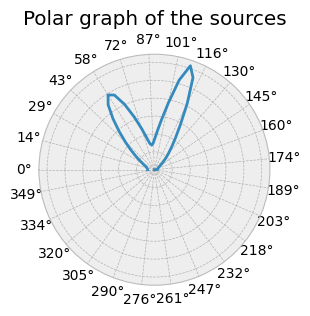

In [6]:
# Finding out where the sources are located
data = []
for i, angle in enumerate(angles):
    temp = np.zeros(num_freqs, dtype=np.complex64)
    for m in range(num_mics):
        channel = input_sound[m]
        stft_res = stft(channel, dft_size, hop_size, zero_pad,
                        window) * np.conj(steering_vector[i][m])
        temp = np.add(stft_res, temp)
    data.append(np.mean(abs(np.sum(temp * np.conj(temp)))**2))

# Create the plot
fig = plt.figure()
ax = fig.add_subplot(111, polar=True)

angles = np.linspace(0, 360, 100)
arr = np.zeros(50)
data = np.concatenate((data, arr))
angles_rad = np.deg2rad(angles)

# Plot the energies
ax.plot(angles_rad, data)

# Customize the plot
ax.set_theta_zero_location("W")
ax.set_theta_direction(-1)
ax.set_xticks(angles_rad[::4])
ax.set_xticklabels([f"{int(x)}°" for x in angles[::4]])
ax.set_yticklabels([])
ax.set_title("Polar graph of the sources")

plt.show()

### Conclusions

Judging from the peaks in the polar graph, I feel like the 2 sources are situated around 60° and 110°.

## Part 3: Beamforming

Identify the angle of the two sources by looking at the peaks from the above result. Let’s call these $\theta_1$ and $\theta_2$. Now that you know where you want to focus the array, you can design two beamformers to focus on the two sources. The steering vectors that you need to use will be $v(\theta_1,:,:)$ and $v(\theta_2,:,:)$. Just as before you need to take each channel’s STFT, multiply each column with the conjugate of the steering vector that corresponds to all the channels and the selected angle to focus on, and then you simply add them all up. The resulting sum will the STFT of the focused output. Use your inverse STFT function to take this back to the time domain and verify that it indeed sounds better than any of the input channels.

In [7]:
# Beamformers to focus on the two sources
peaks, _ = find_peaks(data)
peaks_deg = [round(angles[x], 2) for x in peaks]

sounds = []
for idx in peaks:
    data = np.zeros(num_freqs, dtype=np.complex64)
    for m in range(num_mics):
        channel = input_sound[m]
        stft_res = stft(channel, dft_size, hop_size, zero_pad,
                        window) * np.conj(steering_vector[idx][m])
        data = np.add(stft_res, data)
    sounds.append(np.real(istft(data, dft_size, hop_size, zero_pad)))

for i, theta in enumerate(peaks_deg):
    theta_sound = sounds[i]
    sound(theta_sound, rate=fs, label=f"Sound at {theta}°")

Sound at 58.18°


Sound at 109.09°


### Conclusions

We can hear each of the sounds a lot clearer by using the beamformers.